### This notebook needs to be run in a Cascade environment (https://github.com/HelmchenLabSoftware/Cascade) to use their calcium peak detection

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from scipy.signal import find_peaks
from helpers import * # Here are all the functions needed for this notebook!
import pickle

import os

# cascade2p packages, imported from the downloaded Github repository
from cascade2p import checks
checks.check_packages()
from cascade2p import cascade # local folder

#Each recording interval will be treated separately to avoid jumps in calcium signal resulting to binding of each videos
recording_intervals =[0,545,1909,3273,6000]

	YAML reader installed (version 0.17.21).
	Keras installed (version 2.4.3).
	Tensorflow installed (version 2.3.0).


c:\Users\SimonZ\anaconda3\envs\Cascade\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [3]:
# Define the path to the directory containing files
directory_path = r'C:\Users\SimonZ\Desktop\Code\graffproject\calciumrec\timeseries'
file_paths = []

# Iterate through files in the directory and subdirectories
for root, dirs, files in os.walk(directory_path):
    for file in files:
        file_path = os.path.join(root, file)
        file_paths.append(file_path)

# Print all file paths
for path in file_paths:
    print(path)

# Initialize lists to store calcium recording information
cells = []
total_cell_count = 0
traces_meta = []

# Iterate through each file
for i in range(len(file_paths[:])):
    roi_count = 0

    # Extract parts of the file path
    path_parts = Path(file_paths[i]).parts
    
    # Read data from CSV file
    data = pd.read_csv(file_paths[i], index_col=0)
    
    # Calculate the number of cells in the file
    cell_count = int((data.shape[1]) / 4) # NB /6 for second and third replicate!
    
    # Iterate through each cell in the file
    for j in range(cell_count):
        cell_data = {}
        trace_data = np.array(data["Mean" + str(j + 1)])
        cell_data["Name"] = path_parts[-1][:-4] + '_cell_' + str(j + 1)
        #Part of the recording that is of interest for us
        cell_data["F"] = trace_data[:]
        
        # Append cell information to the cells list
        cells.append(cell_data)
        roi_count += 1
        
    data_point_count = len(trace_data[:])
        
    # Print information about the imported traces
    print("Successfully imported traces from ", file_paths[i])
    print("It has ", roi_count, "cells. Each trace is made of a total of", data_point_count, "datapoints\n")
    
    total_cell_count += roi_count
    
print("Total number of neurons:", total_cell_count)


C:\Users\SimonZ\Desktop\Code\graffproject\calciumrec\timeseries\01.06_Well3_H3_CalcuimRec.csv
C:\Users\SimonZ\Desktop\Code\graffproject\calciumrec\timeseries\31.05_Well5_H3_CalcuimRec.csv
C:\Users\SimonZ\Desktop\Code\graffproject\calciumrec\timeseries\31.05_Well6_H3_CalcuimRec.csv
Successfully imported traces from  C:\Users\SimonZ\Desktop\Code\graffproject\calciumrec\timeseries\01.06_Well3_H3_CalcuimRec.csv
It has  146 cells. Each trace is made of a total of 6000 datapoints

Successfully imported traces from  C:\Users\SimonZ\Desktop\Code\graffproject\calciumrec\timeseries\31.05_Well5_H3_CalcuimRec.csv
It has  99 cells. Each trace is made of a total of 6000 datapoints

Successfully imported traces from  C:\Users\SimonZ\Desktop\Code\graffproject\calciumrec\timeseries\31.05_Well6_H3_CalcuimRec.csv
It has  110 cells. Each trace is made of a total of 6000 datapoints

Total number of neurons: 355


## Each calcium trace will be processed and the ΔF/F0 will be computed. The computation of F0 uses an algorithm implementing a Finite Difference Method (FDM) smoothing.

In [4]:
i=0
for cell in cells:
    cell["F0"] = compute_Fbaseline(cell,recording_intervals)
    cell["dF/F0"] = (cell["F"]-cell["F0"])/cell["F0"]
    i+=1
    printProgressBar(i, total_cell_count, prefix = 'Progress:', suffix = 'Complete')

Progress: |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Complete


In [4]:
# Might be useful to save it there as the previous step takes time! :)
# Save to pickle file
#with open('pause.pkl', 'wb') as pickle_file:
    #pickle.dump(cells, pickle_file)

## Let's look at an example cell. 
The discontinuities result from the different recording intervals that were bound together to produce this full recordings. 

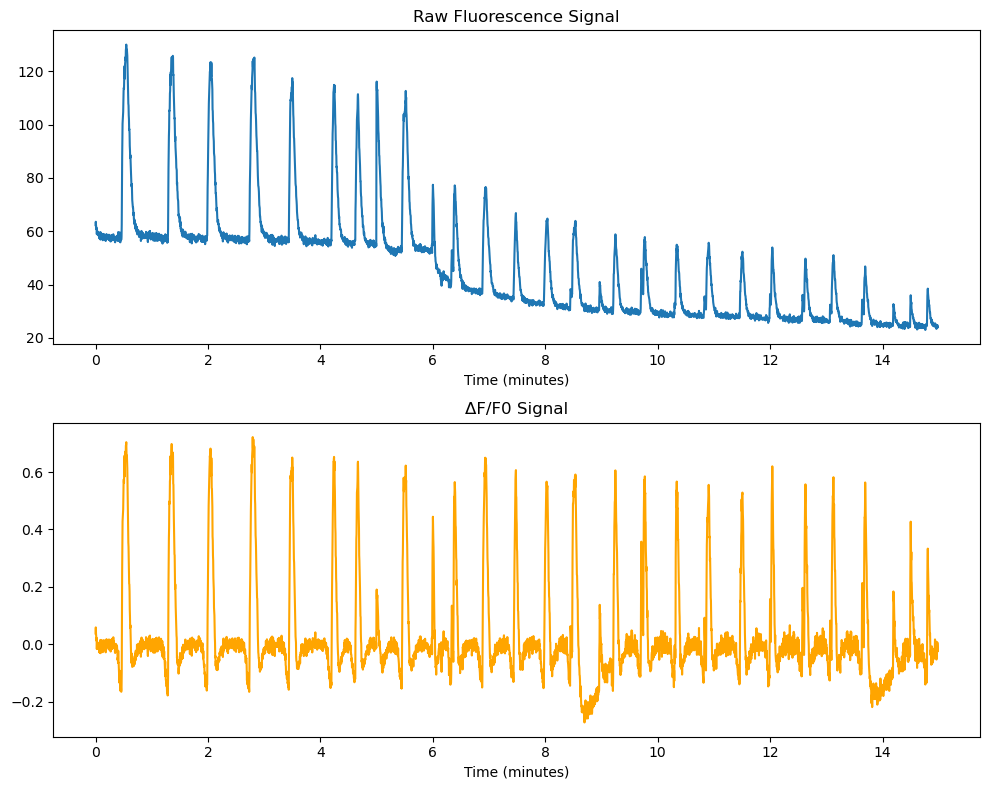

In [5]:
example_cell = cells[1]
frame_rate = 4.55  # frames per second

 # Only focus on the time interval used during the experiment)
F_trace = example_cell["F"][1909:6000]
dFF0_trace = example_cell["dF/F0"][1909:6000]

# Calculate time in minutes
time_minutes = np.arange(len(F_trace)) / (60 * frame_rate)

# Create a figure and axis objects for subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot fluorescence signal in the first subplot
axs[0].plot(time_minutes, F_trace)
axs[0].set_title('Raw Fluorescence Signal')
axs[0].set_xlabel('Time (minutes)')

# Plot dF/F0 in the second subplot
axs[1].plot(time_minutes, dFF0_trace, color='orange')
axs[1].set_title('ΔF/F0 Signal')
axs[1].set_xlabel('Time (minutes)')

# Adjust layout to prevent overlapping
plt.tight_layout()


# Show the plot
plt.show()


## Now we run our algorithm to detect calcium events on ΔF/F0. Here we used the Global_EXC_5Hz_smoothing200ms_causalkernel model from Cascade (https://github.com/HelmchenLabSoftware/Cascade).

In [6]:
# Create a collection of ΔF/F0 traces

dF_F0 = np.array([cell["dF/F0"] for cell in cells])


#Run Cascade peak detection
model_name = "Global_EXC_5Hz_smoothing200ms_causalkernel"
cascade.download_model( model_name,verbose = 1)

spike_prob = cascade.predict( model_name, dF_F0 )


# As Cascade returns the probability of an event to be a spike, we process this output to return the detected events
# This also takes care of artifacts due to the binding of each recording that might have been detected as peaks
for i in range(len(cells)):
    cells[i]["DetectedEvent"] = create_peak_index(cells[i],spike_prob[i],recording_intervals)
    cells[i]["cascade"]=spike_prob[i]

Pretrained model was saved in folder "c:\Users\SimonZ\Desktop\Code\graffproject\Pretrained_models\Global_EXC_5Hz_smoothing200ms_causalkernel"

 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 5Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 200 milliseconds. 
 

Loaded model was trained at frame rate 5 Hz
Given argument traces contains 355 neurons and 6000 frames.
Noise levels (mean, std; in standard units): 0.72, 0.18

Predictions for noise level 2:
	... ensemble 0
261/261 [==============================] - 5s 19ms/step
	... ensemble 1
261/261 [==============================] - 4s 17ms/step
	... ensemble 2
261/261 [==============================] - 5s 17ms/step
	... ensemble 3
261/261 [==============================] - 5s 19ms/step
	... ensemble 4
261/261 [==============================] - 5s 17ms/step

Predictions for noise level 3:
	No neurons for this noise level

Predic

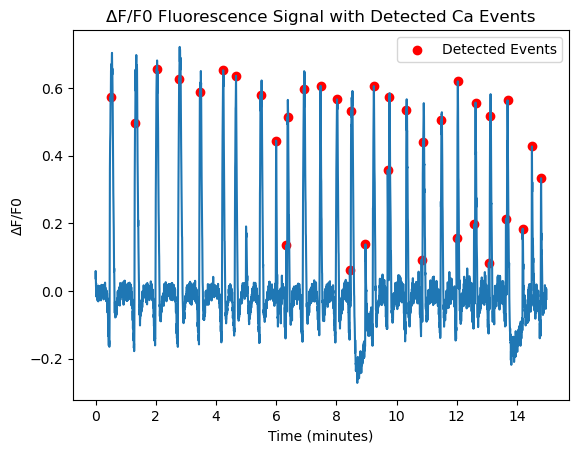

In [14]:
example_cell = cells[1]
frame_rate = 4.55  # frames per second

 # Only focus on the time interval used during the experiment)
dFF0_trace = example_cell["dF/F0"][1909:6000]
# Get the indices and amplitudes of detected events
event_indices = return_info_in_interval(example_cell["DetectedEvent"],[1909,6000])["index"]

# Calculate time in minutes
time_minutes = np.arange(len(dFF0_trace)) / (60 * frame_rate)

# Plot dF/F0 fluorescence signal
plt.plot(time_minutes, dFF0_trace)

# Set title for the subplot
plt.title('ΔF/F0 Fluorescence Signal with Detected Ca Events')



# Plot dots at the positions of detected events (we adjust the value of indices because we only plot from 1909 to 6000)
plt.scatter(time_minutes[event_indices-1909], dFF0_trace[event_indices-1909], color='red', marker='o', label='Detected Events')

# Set labels for x and y axes
plt.xlabel('Time (minutes)')
plt.ylabel('ΔF/F0')


# Add legend
plt.legend()


# Show the plot
plt.show()

## Only neurons activity and a robust peak detection (i.e. similar peak number identified in both ∆F/F0 traces versus a smoothed trace) were kept for analysis

In [13]:
#Compute a smoothed F signal
for cell in cells:
    #Compute a slightly smoothed version of the F trace
    cell["smoothed_F"]=smoothing_FDM(cell["F"],2,recording_intervals)
    #Compute ∆F/F0 from this trace
    cell["dF/F0_smoothedF"] = (cell["smoothed_F"]-cell["F0"])/cell["F0"]

#Run the detection on this smoothed signal -> if the fluctuation is robust enough, a smoothing should not affect their detection

dF_F0_smooth = np.array([cell["dF/F0_smoothedF"] for cell in cells])
spike_prob = cascade.predict( model_name, dF_F0_smooth )

#Create the index for this new detection
for i in range(len(cells)):
    cells[i]["DetectedEvent_smooth"] = create_peak_index(cells[i],spike_prob[i],recording_intervals)
    cells[i]["cascade_smooth"]=spike_prob[i]


 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 5Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 200 milliseconds. 
 

Loaded model was trained at frame rate 5 Hz
Given argument traces contains 355 neurons and 6000 frames.
Noise levels (mean, std; in standard units): 0.08, 0.06

Predictions for noise level 2:
	... ensemble 0
261/261 [==============================] - 4s 16ms/step
	... ensemble 1
261/261 [==============================] - 5s 20ms/step
	... ensemble 2
261/261 [==============================] - 5s 18ms/step
	... ensemble 3
261/261 [==============================] - 5s 20ms/step
	... ensemble 4
261/261 [==============================] - 5s 20ms/step

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions for no

In [15]:


nb_active_cell = len([cell for cell in cells if len(cell["DetectedEvent"]) != 0])

#Check the similarity between the two detection
print("Total number of cells that show activity",nb_active_cell)

# We want to make sure that the detection is robust between frame 1909 and 6000 which correspond to our experimental window 
robustly_detected_cell = detect_robust_cells(cells,[1909,6000])

print("Number of cells that show robust detection", len(robustly_detected_cell))


Total number of cells that show activity 355
Number of cells that show robust detection 159


## Save the result in a pickle file to use in the 2_CombineFRETCA.ipynb jupyter notebook for further analysis

In [16]:


# Save to pickle file
with open('CArobust_cells.pkl', 'wb') as pickle_file:
    pickle.dump(robustly_detected_cell, pickle_file)


